# Gold Prediction ARIMA-GARCH semi model

The purpose of this paper made by Franck Bui Nguyen, is to understand and try to predict gold spot price using several paper research 
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model

# Summary

* Presentation ARIMA(P,D,Q)
*Presentation GARCH(P,Q)
* Implementation

## ARIMA Model

$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$ 

## GARCH Model
Problem with variance, we are using GARCH model to modelise the 2nd moment of a time series

$\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_1 + ... + \alpha_q \epsilon^2_{t-q} = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2$

In [1]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Python Project\Commodities\Data\stocks.csv',index_col=False)
EQD = all.loc[all.type == 'EQD']
CTY = all.loc[all.type == 'CTY']
FX = all.loc[all.type == 'FX']

#Format table
allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

## Cross underlying correlation

Lets calculate the correlation between several underlying

[]

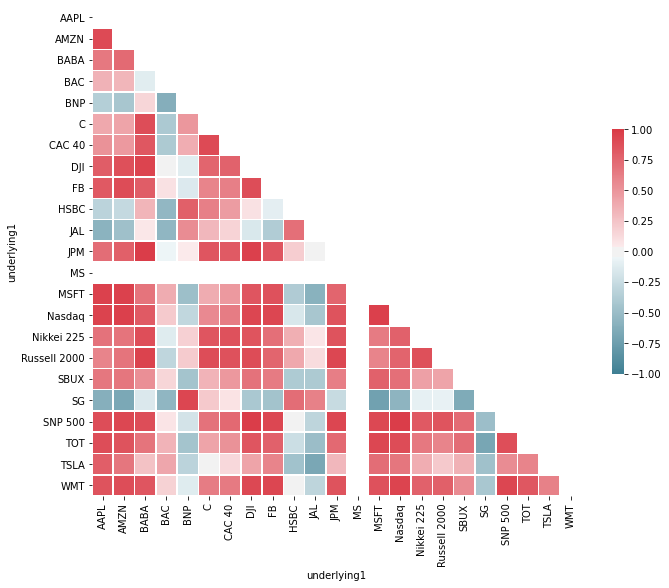

In [3]:
#Calculate correlation between each asset
corrAll, maskALL = dtmgt.corrParam(allFormat)
corrEQD, maskEQD = dtmgt.corrParam(EQDFormat)
corrCTY, maskCTY = dtmgt.corrParam(CTYFormat)
corrFX, maskFX = dtmgt.corrParam(FXFormat)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
dtmgt.corrPlot(corrEQD,maskEQD)

plt.plot()